# Time Series Forecasting for Stock Prices

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [7]:
# Loading data
data = pd.read_csv('ADANIPORTS.csv')  # Adjust the filename
print(data.head())

# Converting the date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Focusing on the closing price
nifty_data = data[['Close']]
print(nifty_data.info())


         Date      Symbol Series  Prev Close    Open     High    Low   Last  \
0  2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0  959.0   
1  2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0  885.0   
2  2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0  887.0   
3  2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0  929.0   
4  2007-12-03  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0  980.0   

    Close    VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  962.90  984.72  27294366  2.687719e+15     NaN             9859619   
1  893.90  941.38   4581338  4.312765e+14     NaN             1453278   
2  884.20  888.09   5124121  4.550658e+14     NaN             1069678   
3  921.55  929.17   4609762  4.283257e+14     NaN             1260913   
4  969.30  965.65   2977470  2.875200e+14     NaN              816123   

   %Deliverble  
0       0.3612  
1       0.3172  
2       0.2088  
3       0.2735  
4

In [9]:
nifty_data.isnull().sum()
nifty_data.fillna(method='ffill', inplace=True)  # Forward fill missing values


C:\Users\jacks\AppData\Local\Temp\ipykernel_11720\3396669169.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_data.fillna(method='ffill', inplace=True)  # Forward fill missing values
C:\Users\jacks\AppData\Local\Temp\ipykernel_11720\3396669169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty_data.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [11]:
scaler = MinMaxScaler()
nifty_data_scaled = scaler.fit_transform(nifty_data)


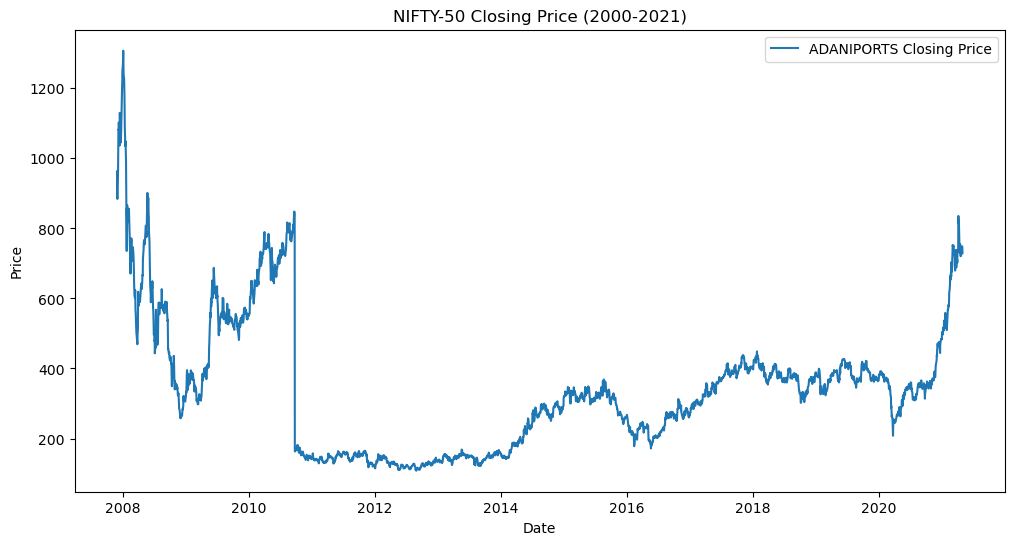

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(nifty_data, label='ADANIPORTS Closing Price')
plt.title('NIFTY-50 Closing Price (2000-2021)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


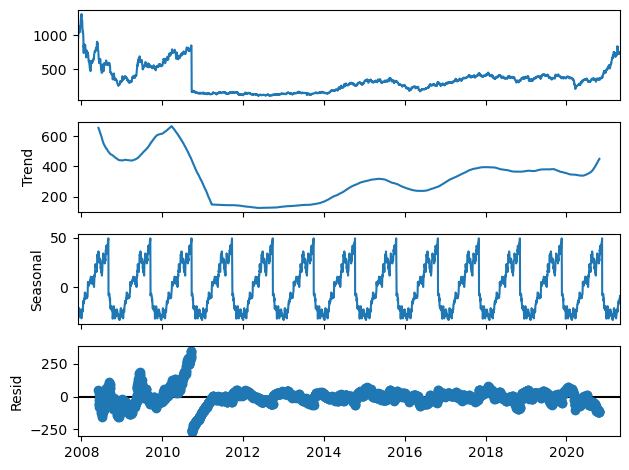

In [17]:
decomposition = seasonal_decompose(nifty_data, model='additive', period=252)
decomposition.plot()
plt.show()


In [19]:
train_size = int(len(nifty_data_scaled) * 0.8)
train, test = nifty_data_scaled[:train_size], nifty_data_scaled[train_size:]


In [21]:
# Training ARIMA
model = ARIMA(train, order=(5, 1, 0))  # Adjust p, d, q
arima_model = model.fit()

# Prediction
arima_predictions = arima_model.forecast(steps=len(test))


In [23]:
# Preparing LSTM data
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60  # 60 days look-back
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshapeing for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Building LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predicting
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)


C:\Users\jacks\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0110
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.0593e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.3732e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.4467e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.9443e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.6541e-04
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 7.2037e-04
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.6774e-04
Epoch 9/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.6968e-04
Epoch 10/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.7196e-04
Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.8600e-04
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.1118e-04
Epoch 13/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.0601e-04
Epoch 14/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 4.5332e-04
Epoch 15/20
82/82 ━

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, arima_predictions)))
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, lstm_predictions)))


ARIMA RMSE: 0.09186162664493412
LSTM RMSE: 410.5428642893997


In [29]:
print(len(nifty_data.index[-len(test):]))
print(len(lstm_predictions))


665
604


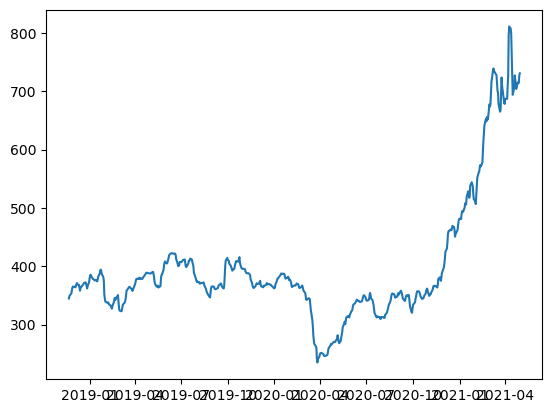

In [31]:
plt.plot(nifty_data.index[-len(lstm_predictions):], lstm_predictions, label='LSTM Predictions')


In [33]:
lstm_predictions = lstm_predictions.ravel()


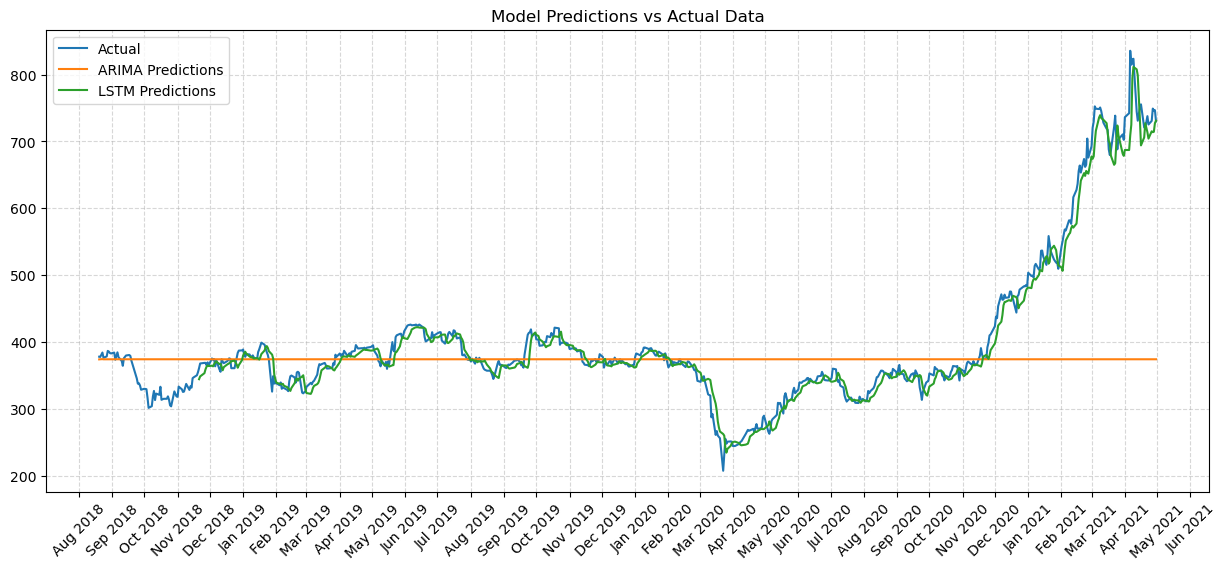

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))  # Wider figure
plt.plot(nifty_data.index[-len(test):], scaler.inverse_transform(test), label='Actual')
plt.plot(nifty_data.index[-len(arima_predictions):], scaler.inverse_transform(arima_predictions.reshape(-1, 1)), label='ARIMA Predictions')
plt.plot(nifty_data.index[-len(lstm_predictions):], lstm_predictions.ravel(), label='LSTM Predictions')

# Formating x-axis
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust ticks to months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Month Year'

# Adding grid, legend, and title
plt.grid(visible=True, which='major', linestyle='--', alpha=0.5)
plt.legend()
plt.title("Model Predictions vs Actual Data")
plt.show()

